In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from tqdm.notebook import tqdm, tnrange
from PIL import Image
import matplotlib.pyplot as plt
import torchsummary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
# Set random seed for reproducibility
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

In [3]:
# lfw_dataset = foz.load_zoo_dataset(
#     "lfw",
#     split="train",
#     shuffle=True,
#     seed=0
# )
# load data from local
lfw_dataset = fo.Dataset.from_dir(
    dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
    dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
    name='lfw_funneled',
    overwrite=True,
)


 100% |█████████████| 13233/13233 [3.6s elapsed, 0s remaining, 3.7K samples/s]      


In [4]:
DIM = 224

In [5]:
class LFWDataset:
    def __init__(self, dataset, dim=DIM):
        self.dataset = dataset
        self.filepaths = list(dataset.values("filepath"))
        self.dim = dim
    
    def __len__(self):
        return len(self.filepaths)
    
    def preprocess(self, image, dim):
        image = image.resize((dim, dim))
        return image
    
    def image_path(self, idx):
        return self.filepaths[idx]
    
    def __getitem__(self, idx):
        impath = self.filepaths[idx]
        sample = self.dataset[impath]
        image = Image.open(impath).convert("RGB")
        image = self.preprocess(image, self.dim)
        image = np.array(image)
        label = sample["ground_truth"]["label"]
        return image, label
    
full_dataset = LFWDataset(lfw_dataset, dim=DIM)
print(full_dataset.image_path(7))
print(lfw_dataset.values("ground_truth.label"))

/home/ichitu/fiftyone/lfw/lfw_funneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdoulaye_Wade', 'Abdoulaye_Wade', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah', 'Abdullah', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullah_al-Attiyah', 'Abdullah_al-Atti

In [6]:
def parse_fglfw_pairs(file_path, dataset_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines()]

    sets = []
    idx = 0
    # Each set has 600 lines for matched (300 pairs) and 600 lines for mismatched (300 pairs)
    for _ in range(10):
        matched = []
        mismatched = []
        # Read 300 matched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            matched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        # Read 300 mismatched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            mismatched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        sets.append({"matched": matched, "mismatched": mismatched})

    return sets

In [7]:
file_path = "/home/ichitu/fiftyone/lfw/lfw_funneled/pair_FGLFW.txt"
pairs = parse_fglfw_pairs(file_path, "/home/ichitu/fiftyone/lfw/lfw_funneled")
print("Parsed", len(pairs), "sets.")
print("Each set has:", len(pairs[0]["matched"]), "matched pairs and", len(pairs[0]["mismatched"]), "mismatched pairs.")

Parsed 10 sets.
Each set has: 300 matched pairs and 300 mismatched pairs.


### Generating batches with anchor, positive and negative

In [8]:
def batch_generator(dataset, pairs, batch_size, dim=DIM, dataset_path="/home/ichitu/fiftyone/lfw/lfw_funneled"):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors_positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    anchors_negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    while True:
        for i in range(batch_size):
            # Select a random set
            set_ = random.choice(pairs)
            # Select a random matched pair
            matched_pair = random.choice(set_["matched"])
            # Select a random mismatched pair
            mismatched_pair = random.choice(set_["mismatched"])
            # Load the images
            anchor_positive = Image.open(matched_pair[0]).convert("RGB")
            positive = Image.open(matched_pair[1]).convert("RGB")
            anchors_negative = Image.open(mismatched_pair[0]).convert("RGB")
            negative = Image.open(mismatched_pair[1]).convert("RGB")
            # Preprocess the images
            anchor_positive = anchor_positive.resize((dim, dim))
            positive = positive.resize((dim, dim))
            anchors_negative = anchors_negative.resize((dim, dim))
            negative = negative.resize((dim, dim))
            # Convert to numpy arrays
            anchor_positive = np.array(anchor_positive)
            positive = np.array(positive)
            anchors_negative = np.array(anchors_negative)
            negative = np.array(negative)
            # Add to the batch
            anchors_positives[0][i] = anchor_positive
            anchors_positives[1][i] = matched_pair[0]
            positives[0][i] = positive
            positives[1][i] = matched_pair[1]
            anchors_positives[0][i] = anchor_positive / 255.
            anchors_positives[1][i] = matched_pair[0].replace(dataset_path + "/","").split("/")[0]
            positives[0][i] = positive / 255.
            positives[1][i] = matched_pair[1].replace(dataset_path + "/","").split("/")[0]
            anchors_negatives[0][i] = anchors_negative / 255.
            anchors_negatives[1][i] = mismatched_pair[0].replace(dataset_path + "/","").split("/")[0]
            negatives[0][i] = negative / 255.
            negatives[1][i] = mismatched_pair[1].replace(dataset_path + "/","").split("/")[0]
        yield [anchors_positives, positives, anchors_negatives, negatives]
        


In [9]:
def batch_generator3(dataset, batch_size, dim=DIM):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
                 [""] * batch_size]

    while True:
        for i in range(batch_size):
            if len(dataset) <= 0:  # Check if the dataset is exhausted
                return  # Stop the generator if the dataset is empty
            anchor_idx = np.random.randint(len(dataset))
            anchor, label = dataset[anchor_idx]
            positive_indices = np.where(np.array(dataset.dataset.values(
                "ground_truth.label")) == label)[0]
            negative_indices = np.where(np.array(dataset.dataset.values(
                "ground_truth.label")) != label)[0]
            if len(positive_indices) == 0 or len(negative_indices) == 0:  
                # Check if no valid pairs are available
                continue
            positive_idx = np.random.choice(positive_indices)
            negative_idx = np.random.choice(negative_indices)
            positive, positive_label = dataset[positive_idx]
            negative, negative_label = dataset[negative_idx]

            anchors[0][i] = anchor
            anchors[1][i] = label
            positives[0][i] = positive
            positives[1][i] = positive_label
            negatives[0][i] = negative
            negatives[1][i] = negative_label

        yield anchors, positives, negatives


Testing what the generator does

In [9]:
BS = 1
generator = batch_generator(full_dataset, pairs, BS)

['Amelie_Mauresmo']
['Amelie_Mauresmo']
['George_Brumley_III']
['Michael_Powell']


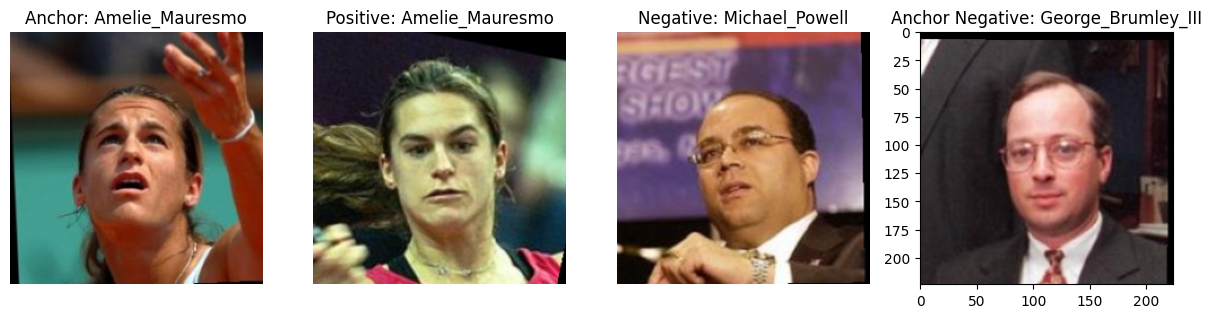

In [10]:
# Get a batch of data
batch = next(generator)
anchor = batch[0]
positive = batch[1]
anchor_negative = batch[2]
negative = batch[3]
print(anchor[1])
print(positive[1])
print(anchor_negative[1])
print(negative[1])
for i in range(BS):
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(anchor[0][i])
    ax[0].set_title("Anchor:" + " " + anchor[1][i])
    ax[0].axis("off")
    ax[1].imshow(positive[0][i])
    ax[1].set_title("Positive:" + " " + positive[1][i])
    ax[1].axis("off")
    ax[2].imshow(negative[0][i])
    ax[2].set_title("Negative:" + " " + negative[1][i])
    ax[2].axis("off")
    ax[3].imshow(anchor_negative[0][i])
    ax[3].set_title("Anchor Negative:" + " " + anchor_negative[1][i])
    plt.show()

# Model


In [147]:
import torch
import torch.nn as nn

class Maxout(nn.Module):
    def __init__(self, input_features, output_features, num_pieces):
        super(Maxout, self).__init__()
        self.num_pieces = num_pieces
        self.linear = nn.Linear(input_features, output_features)

    def forward(self, x):
        shape = x.shape
        x = x.view(-1, shape[2], shape[3], shape[1])
        out = self.linear(x)
        print(out.shape)
        out, _ = torch.max(out, dim=2)
        return out

# Example usage:
input_features = 10
output_features = 5
num_pieces = 2
model = Maxout(input_features, output_features, num_pieces)
input_data = torch.randn(2, 10 , 7 , 7)
print(input_data)
output_data = model(input_data)
print(output_data.shape)


tensor([[[[ 3.4968e-02,  5.2913e-01,  5.7155e-01, -5.4642e-01, -1.1762e+00,
            1.7715e-01,  1.1185e+00],
          [-4.7700e-01,  1.2300e+00,  4.3596e-01, -8.1364e-01,  1.3054e+00,
           -6.9140e-02, -3.1507e-01],
          [ 1.3646e+00,  2.3733e-01,  8.1004e-02,  1.8304e+00,  9.8010e-02,
           -2.5336e+00, -1.1933e+00],
          [-1.1626e+00,  1.0277e+00,  5.1664e-01, -6.0354e-01,  8.0081e-02,
           -1.0189e+00,  7.4103e-01],
          [ 8.8705e-01, -4.7301e-01,  1.0667e+00,  1.5131e-01, -6.3047e-01,
            1.0379e+00, -6.1406e-01],
          [-1.7555e+00, -1.5173e-02,  4.7364e-01,  8.0696e-01, -5.1907e-01,
            8.6584e-01, -6.7371e-01],
          [ 3.0496e-01,  1.6225e+00,  5.4226e-01, -2.1099e-01, -4.2759e-01,
           -3.4250e-01, -1.4534e+00]],

         [[ 2.0280e-01, -6.1726e-01,  4.0238e-01,  9.0781e-01,  2.1666e+00,
            9.7499e-01,  6.5153e-01],
          [ 1.2706e+00, -1.3587e+00,  1.7881e+00, -9.3504e-01, -1.4071e+00,
          

In [171]:
class FaceRecZF(nn.Module):
    def __init__(self, input_shape = (3, 220, 220)):
        super(FaceRecZF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        self.conv2a = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3a = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv4a = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.maxout = Maxout(256,256,2)
        self.fc1 = nn.Linear(256, 128)

    def L2Norm(self, x):
        return F.normalize(x, p=2, dim=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.rnorm1(x)
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2(x))
        x = self.rnorm2(x)
        x = self.pool2(x)
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4a(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5a(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6a(x))
        x = F.relu(self.conv6(x))
        x = self.pool4(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc7132(x)
        return x
    

In [172]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceRecZF().to(device)
torchsummary.summary(model, (3, 220, 220))

torch.Size([2, 256, 7, 7])
torch.Size([2, 12544])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x12544 and 256x128)

In [175]:
class FaceRecInception(nn.Module):
    def __init__(self, input_shape=(3, 220, 220)):
        super(FaceRecInception, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        
        # Inception Module 1
        def inception_block1(in_channels, out_channels):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )    
        self.inception1 = inception_block1(64, [64, 192])

        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Modules 1x1, 3x3, 5x5, and Pooling
        def inception_block1x1(in_channels, out_channels):
            conv1x1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            return nn.Sequential(
                conv1x1,
                nn.ReLU()
            )
        def inception_block3x3(in_channels, out_channels, stride=1):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1, stride=stride)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )
        def inception_block5x5(in_channels, out_channels, stride=1):
            conv5x5_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv5x5 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=5, padding=2, stride=stride)
            return nn.Sequential(
                conv5x5_reduce,
                nn.ReLU(),
                conv5x5,
                nn.ReLU()
            )
        
        class L2Pooling(nn.Module):
            def __init__(self):
                super(L2Pooling, self).__init__()
            def forward(self, x):
                return torch.sqrt(F.avg_pool2d(x**2, kernel_size=3, stride=1, padding=1))

        def pool_proj(in_channels, out_channels, max_pool=True):
            if max_pool:
                return nn.Sequential(
                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                   )
            else:
                return nn.Sequential(
                    L2Pooling(),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                )
        
        # Inception Module 3a
        self.inception3a1x1 = inception_block1x1(192, [64])
        self.inception3a3x3 = inception_block3x3(192, [96, 128])
        self.inception3a5x5 = inception_block5x5(192, [16, 32])
        self.inception3apool = pool_proj(192, 32, max_pool=True)

        # Inception Module 3b
        self.inception3b1x1 = inception_block1x1(256, [64])
        self.inception3b3x3 = inception_block3x3(256, [96, 128])
        self.inception3b5x5 = inception_block5x5(256, [32, 64])
        self.inception3bpool = pool_proj(256, 64, max_pool=False)

        # Inception Module 3c
        self.inception3c3x3 = inception_block3x3(320, [128, 256], stride=2)
        self.inception3c5x5 = inception_block5x5(320, [32, 64], stride=2)
        self.inception3cpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 4a
        self.inception4a1x1 = inception_block1x1(640, [256])
        self.inception4a3x3 = inception_block3x3(640, [96, 192])
        self.inception4a5x5 = inception_block5x5(640, [32, 64])
        self.inception4apool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4b
        self.inception4b1x1 = inception_block1x1(640, [DIM])
        self.inception4b3x3 = inception_block3x3(640, [112, DIM])
        self.inception4b5x5 = inception_block5x5(640, [32, 64])
        self.inception4bpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4c
        self.inception4c1x1 = inception_block1x1(640, [192])
        self.inception4c3x3 = inception_block3x3(640, [128, 256])
        self.inception4c5x5 = inception_block5x5(640, [32, 64])
        self.inception4cpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4d
        self.inception4d1x1 = inception_block1x1(640, [160])
        self.inception4d3x3 = inception_block3x3(640, [144, 288])
        self.inception4d5x5 = inception_block5x5(640, [32, 64])
        self.inception4dpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4e
        self.inception4e3x3 = inception_block3x3(640, [160, 256], stride=2)
        self.inception4e5x5 = inception_block5x5(640, [64, 128], stride=2)
        self.inception4epool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 5a
        self.inception5a1x1 = inception_block1x1(1024, [384])
        self.inception5a3x3 = inception_block3x3(1024, [192, 384])
        self.inception5a5x5 = inception_block5x5(1024, [48, 128])
        self.inception5apool = pool_proj(1024, 128, max_pool=False)

        # Inception Module 5b
        self.inception5b1x1 = inception_block1x1(1024, [384])
        self.inception5b3x3 = inception_block3x3(1024, [192, 384])
        self.inception5b5x5 = inception_block5x5(1024, [48, 128])
        self.inception5bpool = pool_proj(1024, 128, max_pool=True)

        # Final Pooling and Fully Connected Layer
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(1024, 128)

        # L2 Normalization
        def L2Norm(x):
            return F.normalize(x, p=2, dim=1)
        self.L2Norm = L2Norm

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.rnorm1(x)
        x = self.inception1(x)
        x = self.rnorm2(x)
        x = self.max_pool2(x)

        # Inception Module 3a
        inception3a1x1 = self.inception3a1x1(x)
        inception3a3x3 = self.inception3a3x3(x)
        inception3a5x5 = self.inception3a5x5(x)
        inception3apool = self.inception3apool(x)
        x = torch.cat([inception3a1x1, inception3a3x3, inception3a5x5, inception3apool], 1)

        # Inception Module 3b
        inception3b1x1 = self.inception3b1x1(x)
        inception3b3x3 = self.inception3b3x3(x)
        inception3b5x5 = self.inception3b5x5(x)
        inception3bpool = self.inception3bpool(x)
        x = torch.cat([inception3b1x1, inception3b3x3, inception3b5x5, inception3bpool], 1)

        # Inception Module 3c
        inception3c3x3 = self.inception3c3x3(x)
        inception3c5x5 = self.inception3c5x5(x)
        inception3cpool = self.inception3cpool(x)
        x = torch.cat([inception3c3x3, inception3c5x5, inception3cpool], 1)

        # Inception Module 4a
        inception4a1x1 = self.inception4a1x1(x)
        inception4a3x3 = self.inception4a3x3(x)
        inception4a5x5 = self.inception4a5x5(x)
        inception4apool = self.inception4apool(x)
        x = torch.cat([inception4a1x1, inception4a3x3, inception4a5x5, inception4apool], 1)

        # Inception Module 4b
        inception4b1x1 = self.inception4b1x1(x)
        inception4b3x3 = self.inception4b3x3(x)
        inception4b5x5 = self.inception4b5x5(x)
        inception4bpool = self.inception4bpool(x)
        x = torch.cat([inception4b1x1, inception4b3x3, inception4b5x5, inception4bpool], 1)

        # Inception Module 4c
        inception4c1x1 = self.inception4c1x1(x)
        inception4c3x3 = self.inception4c3x3(x)
        inception4c5x5 = self.inception4c5x5(x)
        inception4cpool = self.inception4cpool(x)
        x = torch.cat([inception4c1x1, inception4c3x3, inception4c5x5, inception4cpool], 1)

        # Inception Module 4d
        inception4d1x1 = self.inception4d1x1(x)
        inception4d3x3 = self.inception4d3x3(x)
        inception4d5x5 = self.inception4d5x5(x)
        inception4dpool = self.inception4dpool(x)
        x = torch.cat([inception4d1x1, inception4d3x3, inception4d5x5, inception4dpool], 1)

        # Inception Module 4e
        inception4e3x3 = self.inception4e3x3(x)
        inception4e5x5 = self.inception4e5x5(x)
        inception4epool = self.inception4epool(x)
        x = torch.cat([inception4e3x3, inception4e5x5, inception4epool], 1)

        # Inception Module 5a
        inception5a1x1 = self.inception5a1x1(x)
        inception5a3x3 = self.inception5a3x3(x)
        inception5a5x5 = self.inception5a5x5(x)
        inception5apool = self.inception5apool(x)
        x = torch.cat([inception5a1x1, inception5a3x3, inception5a5x5, inception5apool], 1)

        # Inception Module 5b
        inception5b1x1 = self.inception5b1x1(x)
        inception5b3x3 = self.inception5b3x3(x)
        inception5b5x5 = self.inception5b5x5(x)
        inception5bpool = self.inception5bpool(x)
        x = torch.cat([inception5b1x1, inception5b3x3, inception5b5x5, inception5bpool], 1)

        # Final Pooling and Fully Connected Layer
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        # L2 Normalization
        x = self.L2Norm(x)
        return x

In [176]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_inception = FaceRecInception().to(device)
# print(model)
torchsummary.summary(model_inception, (3, DIM, DIM))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
 LocalResponseNorm-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
              ReLU-7          [-1, 192, 56, 56]               0
 LocalResponseNorm-8          [-1, 192, 56, 56]               0
         MaxPool2d-9          [-1, 192, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          12,352
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 96, 28, 28]          18,528
             ReLU-13           [-1, 96, 28, 28]               0
           Conv2d-14          [-1, 128,

In [13]:
# ...existing code...
for name, param in model_inception.named_parameters():
    print(name, param.mean().item(), param.std().item())
# ...existing code...

conv1.weight -0.00022436170547734946 0.047509655356407166
conv1.bias 0.008638154715299606 0.045431651175022125
inception1.0.weight -0.00036420405376702547 0.07187039405107498
inception1.0.bias 0.004351128824055195 0.07519779354333878
inception1.2.weight 9.830592716753017e-06 0.024053702130913734
inception1.2.bias -0.0014423623215407133 0.023707875981926918
inception3a1x1.0.weight -4.2850115278270096e-05 0.041796084493398666
inception3a1x1.0.bias -0.00039271346759051085 0.04349749535322189
inception3a3x3.0.weight 6.625687819905579e-05 0.041835520416498184
inception3a3x3.0.bias 0.000319700688123703 0.04292555898427963
inception3a3x3.2.weight -4.3252854084130377e-05 0.01962107978761196
inception3a3x3.2.bias 0.0013652064371854067 0.019047334790229797
inception3a5x5.0.weight -7.593985174025875e-06 0.041750483214855194
inception3a5x5.0.bias 0.018245887011289597 0.02925238013267517
inception3a5x5.2.weight -0.0002411288587609306 0.028781991451978683
inception3a5x5.2.bias 0.00208729924634099 0.

In [17]:
# get the number of FLOPs and number of parameters
import torch.profiler

model = FaceRecInception().to(device)
model.eval()
inputs = torch.randn(100, 3, DIM, DIM).to(device)
# Use the profiler to estimate FLOPS
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    with_flops=True
    ) as prof:
    model(inputs)

# Print the profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        43.11%      30.471ms        83.60%      59.088ms       1.001ms      20.140ms        32.72%      20.140ms     341.358us            59            --  
                                        aten::clamp_min         0.76%     540.161us         3.24%       2.288ms      38.140us       6.658ms        10.8

In [18]:
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, inputs)
print(f"FLOPs: {flops.total()/1e9:.2f} G")

Unsupported operator aten::max_pool2d encountered 6 time(s)


Unsupported operator aten::mul encountered 4 time(s)


Unsupported operator aten::pad encountered 2 time(s)


Unsupported operator aten::avg_pool3d encountered 2 time(s)


Unsupported operator aten::add encountered 2 time(s)


Unsupported operator aten::pow encountered 8 time(s)


Unsupported operator aten::div encountered 3 time(s)


Unsupported operator aten::avg_pool2d encountered 7 time(s)


Unsupported operator aten::sqrt encountered 6 time(s)


Unsupported operator aten::linalg_vector_norm encountered 1 time(s)


Unsupported operator aten::clamp_min encountered 1 time(s)


Unsupported operator aten::expand_as encountered 1 time(s)


FLOPs: 159.65 G


In [19]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

In [20]:
def train_triplet_loss(model, generator, optimizer, scheduler, device, epochs=25, bathes_per_epoch=100):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches"), generator):
            anchors, positives, negatives,_ = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [21]:
def quartet_loss_1(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    distance_anchor_negative = F.pairwise_distance(anchor, anchor_negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin)) + torch.mean(F.relu(distance_positive - distance_anchor_negative + margin))
    return loss

In [22]:
def quartet_loss_2(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    distance_anchor_negative = F.pairwise_distance(anchor_negative, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin)) + torch.mean(F.relu(distance_positive - distance_anchor_negative + margin))

In [23]:
def train_quartet_loss(model, generator, optimizer,scheduler, device, epochs=25, bathes_per_epoch=100, loss_fn=quartet_loss_2):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            loss = quartet_loss_1(anchor_positive_embeddings, positive_embeddings, negative_embeddings, anchor_negative_embeddings)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [24]:
def equal_distances(a , b):
    distance_a_b = F.pairwise_distance(a, b)
    # print("Distance between a and b:", distance_a_b)
    return distance_a_b

def pair_triplet_loss(anchor_positive, positive, anchor_negative, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor_positive, positive)
    distance_negative = F.pairwise_distance(anchor_negative, negative)

    # assert equal_distances(distance_positive, distance_negative) != 0, "Distance between anchor-positive and anchor-negative is equal to 0."
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

In [25]:
def train_pair_triplet_loss(model, generator, optimizer, scheduler, device, epochs=25, bathes_per_epoch=100):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            # print(anchor_positive_embeddings, positive_embeddings, anchor_negative_embeddings, negative_embeddings)
            loss = pair_triplet_loss(anchor_positive_embeddings, positive_embeddings, anchor_negative_embeddings, negative_embeddings)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [26]:
# optimizer = optim.SGD(model_inception.parameters(), lr=0.05)
# generator = batch_generator(full_dataset, pairs, 200)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.9, patience=3)
# model_inception, train_losses = train_triplet_loss(model_inception, generator, optimizer, scheduler, device, epochs=2, bathes_per_epoch=5)

In [27]:
# optimizer = optim.Adagrad(model_inception.parameters(), lr=0.05)
# generator = batch_generator(full_dataset, pairs, 150)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2)
# model_inception, train_losses = train_quartet_loss(model_inception, generator, optimizer, scheduler, device, epochs=25, bathes_per_epoch=100)

In [28]:
optimizer = optim.Adam(model_inception.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)
generator = batch_generator(full_dataset, pairs, 150)
model_inception, train_losses = train_pair_triplet_loss(model_inception, generator, optimizer, scheduler, device, epochs=100, bathes_per_epoch=100)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.18545270845293998


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2, Loss: 0.18057340130209923


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3, Loss: 0.17850298419594765


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4, Loss: 0.17945266380906105


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5, Loss: 0.17864915013313293


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6, Loss: 0.17843147173523902


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7, Loss: 0.1796272324025631


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8, Loss: 0.17854809522628784


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9, Loss: 0.17831837981939316


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10, Loss: 0.17981076002120971


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11, Loss: 0.17824368953704833


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12, Loss: 0.17872428625822068


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13, Loss: 0.18007096871733666


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14, Loss: 0.17778716161847113


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 15, Loss: 0.17788821563124657


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16, Loss: 0.17799638137221335


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 17, Loss: 0.1783910249173641


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 18, Loss: 0.1798954625427723


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 19, Loss: 0.1792650744318962


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20, Loss: 0.17783036157488824


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 21, Loss: 0.18043210610747337


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 22, Loss: 0.1793301935493946


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 23, Loss: 0.1791627211868763


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 24, Loss: 0.17990397289395332


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 25, Loss: 0.17871849685907365


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 26, Loss: 0.17837630286812783


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 27, Loss: 0.17956506863236427


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 28, Loss: 0.17910467937588692


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 29, Loss: 0.1787452794611454


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 30, Loss: 0.1787435531616211


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 31, Loss: 0.1791370292007923


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 32, Loss: 0.1795830124616623


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 33, Loss: 0.1770504030585289


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 34, Loss: 0.178462642878294


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 35, Loss: 0.1788926449418068


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 36, Loss: 0.1800342458486557


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 37, Loss: 0.17993780598044395


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 38, Loss: 0.1787989182770252


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 39, Loss: 0.17951365277171136


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 40, Loss: 0.17942356318235397


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 41, Loss: 0.17992339119315148


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 42, Loss: 0.17911455109715463


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 43, Loss: 0.17845701232552527


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 44, Loss: 0.17813490867614745


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 45, Loss: 0.17852903231978418


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 46, Loss: 0.17856884971261025


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 47, Loss: 0.17826120734214781


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 48, Loss: 0.17903125047683716


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 49, Loss: 0.1783985288441181


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 50, Loss: 0.17936726167798042


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 51, Loss: 0.17861916586756707


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 52, Loss: 0.17939380124211313


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 53, Loss: 0.17717679113149643


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 54, Loss: 0.17825529769062995


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 55, Loss: 0.17899195238947868


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 56, Loss: 0.17802757129073143


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 57, Loss: 0.17854682222008705


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 58, Loss: 0.17860011994838715


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 59, Loss: 0.17866889998316765


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 60, Loss: 0.17749817728996276


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 61, Loss: 0.17903584346175194


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 62, Loss: 0.17962830796837806


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 63, Loss: 0.17745750099420549


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 64, Loss: 0.17887828513979911


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 65, Loss: 0.17614183127880095


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 66, Loss: 0.17884020999073982


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 67, Loss: 0.17889344453811645


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 68, Loss: 0.17723943188786506


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 69, Loss: 0.17891708239912987


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 70, Loss: 0.18006504252552985


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 71, Loss: 0.1801472608745098


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 72, Loss: 0.17961597561836243


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 73, Loss: 0.17845699325203895


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 74, Loss: 0.17892916947603227


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 75, Loss: 0.18029196202754974


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 76, Loss: 0.17976533934473993


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 77, Loss: 0.17914770290255547


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 78, Loss: 0.17921763733029367


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 79, Loss: 0.1796756924688816


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 80, Loss: 0.1789795733988285


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 81, Loss: 0.17793966040015222


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 82, Loss: 0.18137011259794236


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 83, Loss: 0.18123380959033966


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 84, Loss: 0.179111507833004


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 85, Loss: 0.17956339821219444


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 86, Loss: 0.17833224430680275


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 87, Loss: 0.17821344435214997


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 88, Loss: 0.17980008095502853


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 89, Loss: 0.1793391762673855


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 90, Loss: 0.17836711794137955


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 91, Loss: 0.18000842541456222


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 92, Loss: 0.18095157116651536


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 93, Loss: 0.17831620901823045


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 94, Loss: 0.17928269252181053


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 95, Loss: 0.17940650030970573


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96, Loss: 0.1787465228140354


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 97, Loss: 0.17861373975872993


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 98, Loss: 0.17875466108322144


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99, Loss: 0.17825800612568854


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100, Loss: 0.17890693992376328
Finished Training


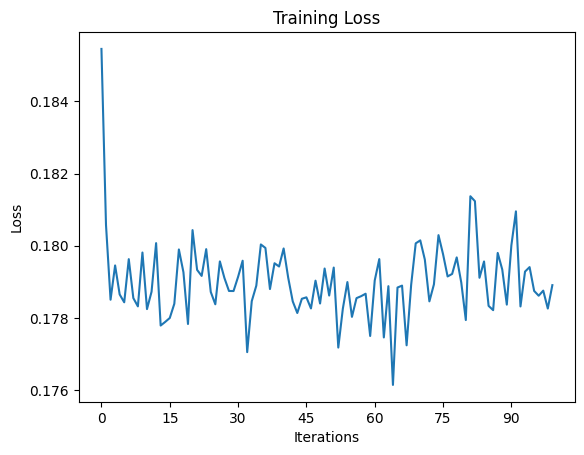

In [29]:
# plot the training loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
ax.plot(train_losses)

In [30]:
# Save the model with timestamp and dimension
tmstmp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model_inception.state_dict(), "{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp))

# clean cuda memory
torch.cuda.empty_cache()

In [31]:
def evaluate3(model, generator, device, batches):
    model.eval()
    tabel_data = "| Anchor - Positive | Anchor - Negative |\n" +\
                 "|" + 19*"-" + "+" + 19*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tnrange(batches, desc="Batches", leave=False), generator):
            anchors, positives, negatives = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32)

            anchors = torch.transpose(anchors, 1, 3)
            positives = torch.transpose(positives, 1, 3)
            negatives = torch.transpose(negatives, 1, 3)
            # print(anchors.shape, positives.shape, negatives.shape)

            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            distance_positive = F.pairwise_distance(anchor_embeddings, positive_embeddings)
            distance_negative = F.pairwise_distance(anchor_embeddings, negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors)):
                tabel_data = f"| {distance_positive[j]:.15f} | {distance_negative[j]:.15f} |"
                print(tabel_data)

In [14]:
def evaluate(model, generator, device, batches):
    model.eval()
    tabel_data = "| Anchor - Positive | Anchor - Negative |\n" +\
                 "|" + 19*"-" + "+" + 19*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tqdm(range(batches), desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            distance_positive = F.pairwise_distance(anchor_positive_embeddings, positive_embeddings)
            distance_negative = F.pairwise_distance(anchor_positive_embeddings, negative_embeddings)
            distance_anchor_negative = F.pairwise_distance(anchor_positive_embeddings, anchor_negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors_positives)):
                tabel_data = f"| {distance_positive[j]:.15f} | {distance_negative[j]:.15f} |"
                print(tabel_data)
            



In [16]:
generator = batch_generator(full_dataset, pairs, 256)
model_inception = FaceRecInception().to(device)
state_dict = torch.load("{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp), weights_only=True)
# Remove 'module.' prefix from keys if present
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model_inception.load_state_dict(state_dict=state_dict)
evaluate(model_inception, generator, device, batches=2)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

| Anchor - Positive | Anchor - Negative |
|-------------------+-------------------|
| 0.080052077770233 | 0.062257286161184 |
| 0.134238660335541 | 0.100332856178284 |
| 0.056973431259394 | 0.047981325536966 |
| 0.050918255001307 | 0.073148816823959 |
| 0.165066704154015 | 0.074685610830784 |
| 0.043125677853823 | 0.125495329499245 |
| 0.082683958113194 | 0.138108000159264 |
| 0.117531329393387 | 0.111573539674282 |
| 0.125867128372192 | 0.130097925662994 |
| 0.093226037919521 | 0.212121129035950 |
| 0.208054021000862 | 0.072185263037682 |
| 0.055752951651812 | 0.196618318557739 |
| 0.104976519942284 | 0.138862013816833 |
| 0.206345498561859 | 0.078221842646599 |
| 0.161396279931068 | 0.183802217245102 |
| 0.026148302480578 | 0.020443338900805 |
| 0.292866498231888 | 0.271433502435684 |
| 0.152008116245270 | 0.372260987758636 |
| 0.112518258392811 | 0.163644462823868 |
| 0.035732183605433 | 0.082401014864445 |
| 0.302209228277206 | 0.014685114845634 |
| 0.307708591222763 | 0.0768417790

Positive Distance: 0.046759869903326035
 Negative Distance: 0.20436006784439087
  Anchor Negative Distance: 0.10072756558656693 
   Anchor Negative - Negative Distance: 0.2959892749786377


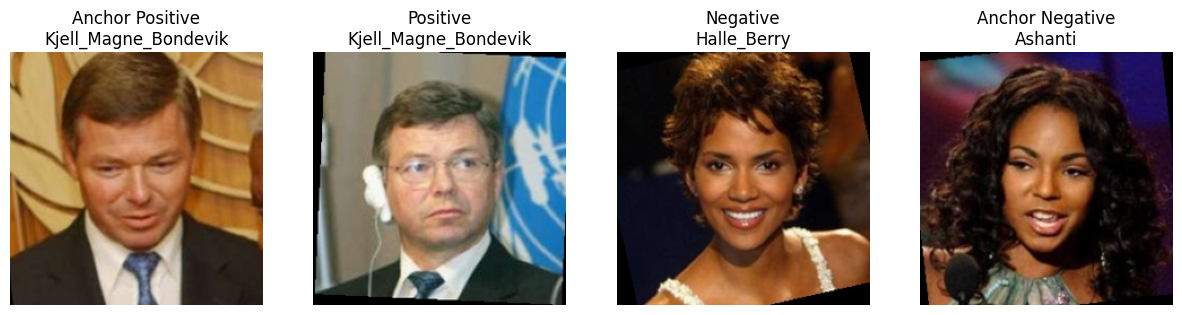

In [17]:
image_generator = batch_generator(full_dataset, pairs, 1)
an_data, pos_data, an_neg_data, neg_data = next(image_generator)
an = torch.tensor(an_data[0], device=device, dtype=torch.float32)
pos = torch.tensor(pos_data[0], device=device, dtype=torch.float32)
neg = torch.tensor(neg_data[0], device=device, dtype=torch.float32)
an_neg = torch.tensor(an_neg_data[0], device=device, dtype=torch.float32)
an_t = torch.transpose(an, 1, 3)
pos_t = torch.transpose(pos, 1, 3)
neg_t = torch.transpose(neg, 1, 3)
an_neg_t = torch.transpose(an_neg, 1, 3)
an_emb = model_inception(an_t)
pos_emb = model_inception(pos_t)
neg_emb = model_inception(neg_t)
an_neg_emb = model_inception(an_neg_t)
distance_positive = F.pairwise_distance(an_emb, pos_emb)
distance_negative = F.pairwise_distance(an_emb, neg_emb)
distance_an_neg = F.pairwise_distance(an_emb, an_neg_emb)
distance_an_neg_negatives = F.pairwise_distance(an_neg_emb, neg_emb)
print(f"Positive Distance: {distance_positive.item()}\n Negative Distance: {distance_negative.item()}\n",
      f" Anchor Negative Distance: {distance_an_neg.item()} \n   Anchor Negative - Negative Distance: {distance_an_neg_negatives.item()}")
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 4, 1)
ax.imshow(an[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Positive\n{an_data[1][0]}")
ax = plt.subplot(1, 4, 2)
ax.imshow(pos[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Positive\n{pos_data[1][0]}")
ax = plt.subplot(1, 4, 3)
ax.imshow(neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Negative\n{neg_data[1][0]}")
ax = plt.subplot(1, 4, 4)
ax.imshow(an_neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Negative\n{an_neg_data[1][0]}")
plt.show()


In [35]:
# Check if weights are zero
for name, param in model_inception.named_parameters():
    print(f"{name} - mean: {param.mean().item()}, std: {param.std().item()}")

# Check if gradients are zero
for name, param in model_inception.named_parameters():
    if param.grad is not None:
        print(f"{name} grad - mean: {param.grad.mean().item()}, std: {param.grad.std().item()}")

conv1.weight - mean: -0.017176099121570587, std: 0.06359270960092545
conv1.bias - mean: -0.06052035838365555, std: 0.08941839635372162
inception1.0.weight - mean: 0.004024432972073555, std: 0.08126430213451385
inception1.0.bias - mean: -0.062383003532886505, std: 0.13474653661251068
inception1.2.weight - mean: -0.0024505744222551584, std: 0.04338458925485611
inception1.2.bias - mean: -0.056400321424007416, std: 0.06285006552934647
inception3a1x1.0.weight - mean: 0.001835708855651319, std: 0.0546276718378067
inception3a1x1.0.bias - mean: -0.02222888544201851, std: 0.06800954788923264
inception3a3x3.0.weight - mean: 0.0014359323540702462, std: 0.05757137015461922
inception3a3x3.0.bias - mean: -0.04902119189500809, std: 0.06043104827404022
inception3a3x3.2.weight - mean: 0.0029882180970162153, std: 0.04353911057114601
inception3a3x3.2.bias - mean: -0.011838860809803009, std: 0.04945547878742218
inception3a5x5.0.weight - mean: -0.006139393895864487, std: 0.05228954181075096
inception3a5x5.

inception5b5x5.0.weight - mean: -0.0003093997947871685, std: 0.04469903185963631
inception5b5x5.0.bias - mean: -0.0005376720800995827, std: 0.04545637592673302
inception5b5x5.2.weight - mean: -0.0035798526369035244, std: 0.04123515263199806
inception5b5x5.2.bias - mean: -0.008635399863123894, std: 0.05216361582279205
inception5bpool.1.weight - mean: -0.003585629165172577, std: 0.037100132554769516
inception5bpool.1.bias - mean: -0.005645494908094406, std: 0.0421922504901886
fc1.weight - mean: -0.0002484832948539406, std: 0.04898393899202347
fc1.bias - mean: 0.0038449352141469717, std: 0.054907795041799545


In [19]:
# Verify loss function
generator = batch_generator(full_dataset, pairs, 1)
model_inception = FaceRecInception().to(device)
optimizer = optim.Adam(model_inception.parameters(), lr=0.01)

# Ensure optimizer is updating parameters
for epoch in range(10):
    optimizer.zero_grad()
    anchors, positives, anchors_negatives, negatives = next(generator)
    anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
    positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
    negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
    anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

    
    anchor_embeddings = model_inception(anchors)
    positive_embeddings = model_inception(positives)
    negative_embeddings = model_inception(negatives)
    anchor_negative_embeddings = model_inception(anchors_negatives)
    
    loss = pair_triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings, anchor_negative_embeddings)
    loss.backward()
    optimizer.step()
    
    print(f"Loss: {loss.item()}")
    for name, param in model_inception.named_parameters():
        if param.grad is not None:
            print(f"{name} grad - mean: {param.grad.mean().item()}, std: {param.grad.std().item()}")

NameError: name 'pair_triplet_loss' is not defined

In [20]:
random_samples = fo.Dataset.from_dir(
    dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
    dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
    name='lfw_funneled_random',
    overwrite=True,
    max_samples=50
    
)
random_dataset = LFWDataset(random_samples)

 100% |███████████████████| 50/50 [23.6ms elapsed, 0s remaining, 2.1K samples/s]      


In [21]:
def preprocess_image(image):
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    # image = F.normalize(image)
    image = image.unsqueeze(0)
    return image

def get_image(image):
    return Image.fromarray(image)

def get_images(images):
    return [get_image(image) for image in images]

def get_image_from_sample(sample):
    return get_image(np.array(sample[0]))

def get_images_from_samples(samples):
    return [get_image_from_sample(sample) for sample in samples]

print(len(random_dataset))
images = get_images_from_samples(random_dataset)
print(len(images))

50
50


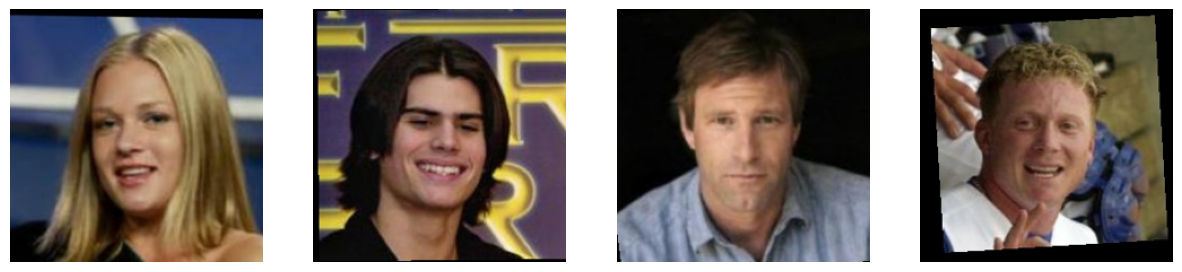

In [22]:
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.axis("off")

In [23]:
def get_embedding(image):
    image = preprocess_image(image)
    # print(image.shape)
    # plt.imshow(image[0])
    # get image on cuda
    image = image.cuda()
    # get embedding
    embedding = model_inception(image)
    return embedding.cpu().detach().numpy()

def get_embeddings(images):
    embeddings = []
    for image in tqdm(images):
       embeddings.append(get_embedding(image))
    return np.array(embeddings)

In [24]:
embeddings = get_embeddings(images)
embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[2])
print(embeddings.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 128)


In [36]:
# get all abdulah_gul images
abdullah_gul_samples = random_samples.match({"ground_truth.label": "Abdullah_Gul"})
abdullah_gul_dataset = LFWDataset(abdullah_gul_samples)
abdullah_gul_images = get_images_from_samples(abdullah_gul_dataset)
abdullah_gul_embeddings = get_embeddings(abdullah_gul_images)
# check pair_wise distance between abdullah_gul images

for i in range(len(abdullah_gul_samples)):
    for j in range(i+1, len(abdullah_gul_samples)):
        print(F.pairwise_distance(torch.tensor(abdullah_gul_embeddings[i]), torch.tensor(abdullah_gul_embeddings[j])).item())

  0%|          | 0/19 [00:00<?, ?it/s]

2.5236071451217867e-05
2.0719213353004307e-05
1.7089936591219157e-05
1.4182818631525151e-05
1.7725966245052405e-05
2.0958728782716207e-05
1.96463934116764e-05
1.8423428628011607e-05
2.3879945729277097e-05
1.69116428878624e-05
2.319621307833586e-05
1.6482206774526276e-05
2.4074215616565198e-05
2.0656141714425758e-05
1.8659704437595792e-05
2.250655961688608e-05
2.084414336422924e-05
1.564355807204265e-05
1.4451638890022878e-05
1.7994634617934935e-05
2.253346065117512e-05
1.9375569536350667e-05
1.3744761417910922e-05
1.7261578250327148e-05
1.6951787983998656e-05
1.4196449228620622e-05
1.953007267729845e-05
1.4319716683530714e-05
1.8606160665513016e-05
1.4343699149321765e-05
1.6746995243011042e-05
1.5248895579134114e-05
1.6452935597044416e-05
1.638815228943713e-05
1.9420132957748137e-05
1.5811203411431052e-05
1.8601411284180358e-05
1.5808172975084744e-05
1.3055000636086334e-05
1.4162155821395572e-05
1.423191588401096e-05
1.4281272342486773e-05
1.666509524511639e-05
1.4955457118048798e-05
1

In [26]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

esults = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_tsne_manual",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "manual",
    points = TSNE(n_components=3).fit_transform(embeddings)
)

results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_umap",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "umap",
)

results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_pca_manual",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "manual",
    points = PCA(n_components=3).fit_transform(embeddings)
)

Generating visualization...


/home/ichitu/machine-learning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Fri Jan 17 11:03:30 2025 Construct fuzzy simplicial set
Fri Jan 17 11:03:30 2025 Finding Nearest Neighbors
Fri Jan 17 11:03:34 2025 Finished Nearest Neighbor Search
Fri Jan 17 11:03:35 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Jan 17 11:03:37 2025 Finished embedding


In [1]:

sess = fo.launch_app(dataset=random_samples, port=10100)
sess.open_tab()

NameError: name 'fo' is not defined